In [5]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')



In [ ]:
# For simplicity we assume a normal distribution of mean(mu) piror  
# mean(mu) ~ Normal(0,1) and Liklihood (x|w ~ Normal(mu=0, std=1)
# So our posterior becomes P(w|x) = p(w) * p(x|w) / p(x)
# Here w are the weight parameters, which in this case are the mu and sigma

# Now that the priors of the mu and sigma are conjugate which means that the proterior distribution would take the
# same distribution as that of the priors
# Anlytical calculation of posterior for the mu and sigma:

[-1.0856306   0.99734545  0.2829785  -1.50629471 -0.57860025  1.65143654
 -2.42667924 -0.42891263  1.26593626 -0.8667404  -0.67888615 -0.09470897
  1.49138963 -0.638902   -0.44398196 -0.43435128  2.20593008  2.18678609
  1.0040539   0.3861864 ]


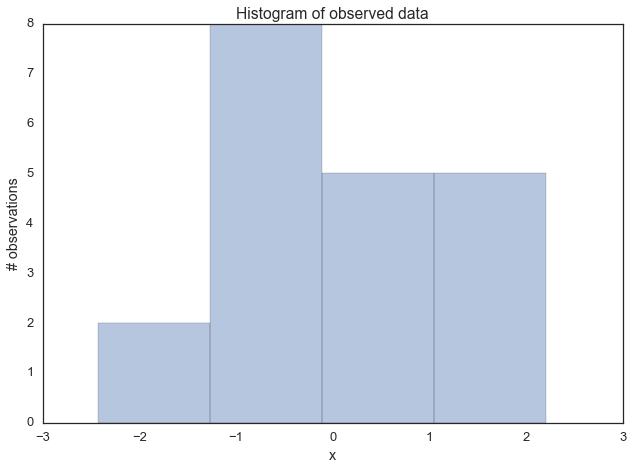

In [33]:
# Generate and vizualize data:
x = np.linspace(-1,1,500)
np.random.seed(123)
# Generate random 20 numbers
observed_data = np.random.randn(20)
print (observed_data)
ax = plt.subplot()
sns.distplot(observed_data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

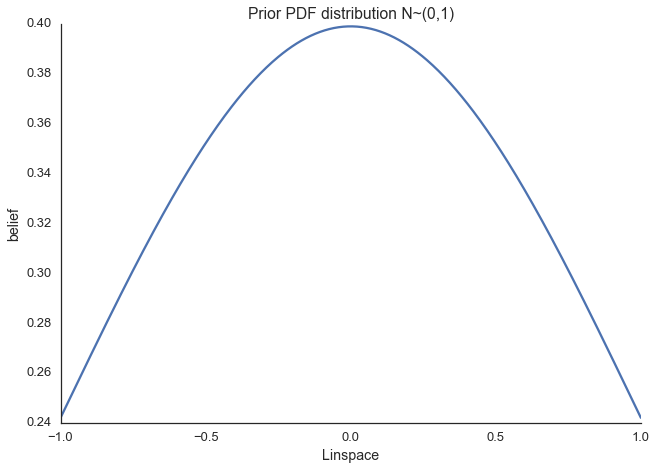

In [34]:
# Prior using parameters mu and sigma, where mu=0 and sigma=1.
mu_prior = 0
sigma_prior = 1
ax = plt.subplot()
prior_dist = norm(mu_prior, sigma_prior).pdf(x)
ax.plot(x, prior_dist)
ax.set(xlabel='Linspace', ylabel='belief', title='Prior PDF distribution N~(0,1)');
sns.despine()
    

[-1.0856306   0.99734545  0.2829785  -1.50629471 -0.57860025  1.65143654
 -2.42667924 -0.42891263  1.26593626 -0.8667404  -0.67888615 -0.09470897
  1.49138963 -0.638902   -0.44398196 -0.43435128  2.20593008  2.18678609
  1.0040539   0.3861864 ]
The parameter mu from the given data is:  0.114417731955
The parameter sigma from the given data is:  1.22561326874


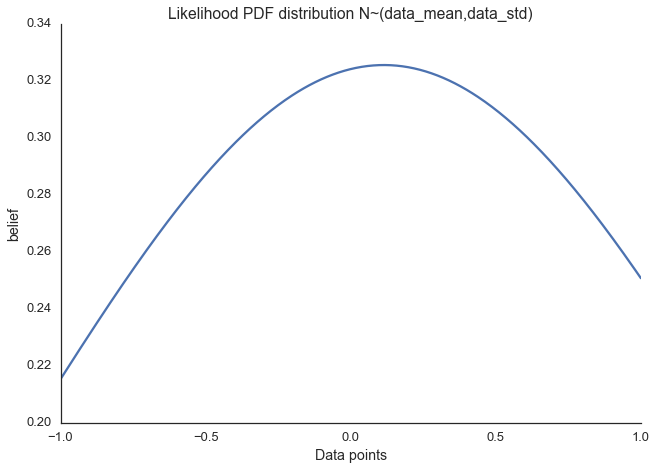

In [35]:
# Likelihood using parameters mu and sigma using the observed data.
# When We have some data points 
print (data)  # Lets say our data is generater from a random sample

mu_likelihood = np.mean(data)
sigma_likelihood = np.std(data)

print ('The parameter mu from the given data is: ', mu_likelihood)
print ('The parameter sigma from the given data is: ', sigma_likelihood)

likelihood = norm(mu_likelihood, sigma_likelihood).pdf(x)
ax = plt.subplot()
ax.plot(x, likelihood)
ax.set(xlabel='Data points', ylabel='belief', title='Likelihood PDF distribution N~(data_mean,data_std)');
sns.despine()

0.0544846342644

0.047619047619047616


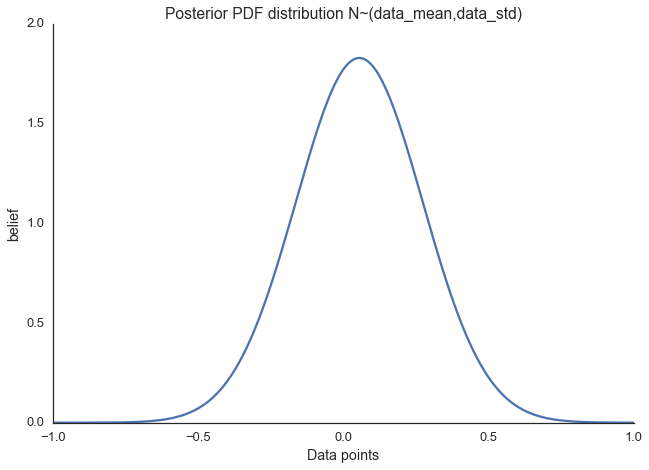

In [40]:
# Posterior distribution is calculated by the use of prior and likelihood.
# In the 2nd plot we have a pdf distribution using parameters (mu=0 and sigma=1)
# In the 3rd plot we have a pdf distribution using parameters fetched from the data (mu=0.114417731955 and sigma=1.22561326874)
def posterior_analytical(data, mu_0, sigma_0):
    sigma = 1.   # Taking a constant variance for the "data"
    n = len(data)
    """
        Since the priors are conjugate the posterior has the same distribution as that of the prior. Using maximum 
        likelihood estimation and prior we have them as below.

        posterior P(mu|data) = P(mu|mu_0,sigma_0) * P(x1,x2,···,xn|mu, sigma) / normalizer
        since we are using Gaussiam distribution,
        
        P(mu|mu_0,sigma_0) = 1/sq(sigma_0)*exp(-1/2*sq(sigma_0)sq(mu - mu_0)), and
        P(x1,x2,···,xn|mu, mu_0, sigma_0) = 1/(sigma_0)**n * exp(-1/2*sq(sigma)sum(sq(mu - mu_0)))
        
        Similarly we get the posterior for sigma.
    
        using Schur complement of matrix we get the below simplified version of prior, likelihood and posterior
    """
    mu_prior = (sigma_0**2/(sigma**2 + sigma_0**2)) * mu_0           # we have sigma_0 and mu_0 leading because they are the prior belief
    mu_liklihood = (sigma**2/(sigma**2 + sigma_0**2)) * np.sum(data)
    mu_normalizer =  (1. / sigma_0**2) + (n / sigma**2)
    
    mu_post = mu_prior + mu_liklihood / mu_normalizer
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1

    print (mu_post)
    print ('')
    print (sigma_post)
    return mu_post, sigma_post #norm(mu_post, np.sqrt(sigma_post)).pdf(x)

mu_post, sigma_post = posterior_analytical(observed_data, 0., 1.)
posterior = norm(mu_post, np.sqrt(sigma_post)).pdf(x)
ax = plt.subplot()
ax.plot(x, posterior)
ax.set(xlabel='Data points', ylabel='belief', title='Posterior PDF distribution N~(data_mean,data_std)');
sns.despine()



In [60]:
# In reality we would not have conjugate scenario. So our posterior would simply be the multiple of the 
# likelihood and the prior. In MCMC we dont find the entire posterior distribution posterior distribution, 
# we just take random samples and jump to a parameter setting if the posterior for the current parameter in better'
# the posterior for the previous parameter setting.

# In the example we are using the parameters are the mean(mu) and the standard deviation (sigma). We would compute the
# likelihood anf the prior for each parameter anf then evaluate if the posterior for the current parameter setting increaes.
# If so then we make a jump in the direction of the new parameter settings.

# In the following code we however assume a constant variance. Also to calculate the likelihood normally we should use
# the sum of log probabilities, however in this case for simplicity we just get the probability of each data point given the 
# parameters and then multiply them. In practise this may result in vanishing or exploding of parameters. So in practise
# we may use the maximum likelihood estimation to do the likelihood part.

def sample_parameters_chck_posterior(samples, data, mu_imit=0.5, proposal_width=0.5, mu_prior=0, sigma_prior=1, plot=None):
    mu_current = mu_imit
    posterior_dist = [mu_current]
    for i in np.arange(samples):
        # sample(Generate) a new mean
        mu_new = norm(mu_current, proposal_width).rvs()
#         print (mu_new)
        
        # Calculate the new likelihood, prior and posterior for the new parameter (mean).
        # norm(mu_current,1).pdf(data) will create the likelihood of all the data given the mean and prod()
        # will take the product of all the probability.
        likelihood_current = norm(mu_current,1).pdf(data).prod()
        likelihood_new = norm(mu_new,1).pdf(data).prod()
#         print(likelihood_current) # You will observe that the likelihood becomea a very small number approximating 1-e7
#         print(likelihood_new)
        
        # Calculating the priors
        prior_current = norm(mu_prior,sigma_prior).pdf(mu_current)  # Will product a simgle number because mu_current is just one value
        prior_new = norm(mu_prior,sigma_prior).pdf(mu_new)
        
        # Calculating the posterior without Normalization:
        posterior_current = prior_current * likelihood_current
        posterior_new = prior_new * likelihood_new
#         print(posterior_current) 
#         print(posterior_new)
        
        # Calculating the posterior probability.
        # If we divide the posterior_new be posterior_current the normalizing term in the denominator gets cancelled out
        # So for practical scenario we dont consider the normalizing term.
        posterior_prob = posterior_new/posterior_current
        # if the new posteriar is really bigger than than the posterior_current, this means that the data has bigger 
        # likelihood given the new parameter mu_new.
        
        print ('posterior_prob ', posterior_prob)
        
        if np.random.rand()<= posterior_prob:   # Only when the posterior probability is greater than a certain random
            mu_current = mu_new                 # sample we jump to the mu_new else we dont. Note that we may have a 
                                                # sampling error. However thats acceptable because the overall method is computationally effective
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        # Now we store the posterior probability
        posterior_dist.append(mu_current)
    return posterior_dist

posterior_dist = sample_parameters_chck_posterior(10, data=observed_data)
print (posterior_dist)

posterior_prob  3.41798434985
posterior_prob  1.232286973
posterior_prob  0.00302431184586
posterior_prob  0.717568377522
posterior_prob  0.374979881609
posterior_prob  0.000625737829217
posterior_prob  0.0405155810995
posterior_prob  1.7812846761
posterior_prob  1.07137643104
posterior_prob  0.627702498429
[0.5, 0.2983169809489462, 0.23530218829243865, 0.23530218829243865, -0.10913230363102211, -0.2665113769897521, -0.2665113769897521, -0.2665113769897521, -0.18429076187483961, 0.3908120093984765, -0.24286401510663724]
